In [ ]:
from functools import reduce
import numpy as np
from operator import add
from random import uniform, seed, shuffle
from scipy import spatial

import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

seed = 10

In [ ]:
# нужно, чтобы запустить анимацию в Colab
from matplotlib import rc
rc('animation', html='jshtml')

# **1. Муравьиный алгоритм: один муравей**

In [ ]:
# инициализация параметров
alfa, beta = 1, 1
Q, P = 10, 0.15

# количество муравьев, вершин
k, n = 1, 5

# матрица расстояний
matrix_D = [
     [None, 38, 74, 59, 45],
     [38, None, 46, 61, 72],
     [74, 46, None, 49, 85],
     [59, 61, 49, None, 42],
     [45, 72, 85, 42, None]
     ]

# матрица феромонов
matrix_T = [[0 for _ in range(n)] for _ in range(n)]

for i in range(n):
    matrix_T[i][i] = None
    for j in range(i):
        matrix_T[i][j] = 0.2
        matrix_T[j][i] = 0.2

# матрица видимостей
matrix_N= [[0 for _ in range(n)] for _ in range(n)]

for i in range(n):
    for j in range(i):
        matrix_N[i][j] = 1 / matrix_D[i][j]
        matrix_N[j][i] = 1 / matrix_D[i][j]

# посещенные вершины и путь
tabu_list = []
not_tabu_list = [i for i in range(1, n + 1)]
path = []

# выбор первой вершины
u = 1
tabu_list.append(u)
not_tabu_list.remove(u)
path.append(u) 

In [ ]:
counter = 0

while len(tabu_list) < 5:
    counter += 1
    print(f'ИТЕРАЦИЯ {counter}\nПосещенные вершины: {tabu_list}\n'
        f'Непосещенные вершины: {not_tabu_list}\nПуть: {path}')
    
    probas = []
    reduced_probas = []
    total = 0

    for v in not_tabu_list:
        total += matrix_T[u - 1][v - 1] ** alfa * matrix_N[u - 1][v - 1] ** beta
    
    for v in not_tabu_list:
        proba = matrix_N[u - 1][v - 1] ** alfa * matrix_T[u - 1][v - 1] ** beta / total
        probas.append(proba)
        reduced_probas.append(reduce(add, probas))
    
    number = uniform(0, 1)
    print(f'\nСлучайное число: {number}\nНакопленные вероятности: {reduced_probas}')
    
    for i, proba in enumerate(reduced_probas):
        if number < proba:
            u = not_tabu_list[i]
            tabu_list.append(u)
            not_tabu_list.remove(u)
            path.append(u)
            print(f'Выбрана вершина: {u}\n')
            break

print('Весь путь:', end=' ')
path.append(path[0])
path

ИТЕРАЦИЯ 1
Посещенные вершины: [1]
Непосещенные вершины: [2, 3, 4, 5]
Путь: [1]

Случайное число: 0.9405611096194549
Накопленные вероятности: [0.3331084013780756, 0.5041640669506009, 0.718708461058514, 1.0]
Выбрана вершина: 5

ИТЕРАЦИЯ 2
Посещенные вершины: [1, 5]
Непосещенные вершины: [2, 3, 4]
Путь: [1, 5]

Случайное число: 0.470895653363252
Накопленные вероятности: [0.2807928268050967, 0.5186408683341198, 0.9999999999999999]
Выбрана вершина: 3

ИТЕРАЦИЯ 3
Посещенные вершины: [1, 5, 3]
Непосещенные вершины: [2, 4]
Путь: [1, 5, 3]

Случайное число: 0.8466705056966253
Накопленные вероятности: [0.5157894736842106, 1.0]
Выбрана вершина: 4

ИТЕРАЦИЯ 4
Посещенные вершины: [1, 5, 3, 4]
Непосещенные вершины: [2]
Путь: [1, 5, 3, 4]

Случайное число: 0.974723695817588
Накопленные вероятности: [1.0]
Выбрана вершина: 2

Весь путь: 

[1, 5, 3, 4, 2, 1]

In [ ]:
# расчет длины пути
lenght = 0

for i, j in enumerate(path[1:]):
    lenght += matrix_D[path[i] - 1][j - 1]

print('Длина пути:', lenght)

# обновление матрицы феромонов
delta = Q / lenght

for i, j in enumerate(path[1:]):
    matrix_T[path[i] - 1][j - 1] = matrix_T[path[i] - 1][j - 1] * (1 - P) + delta

matrix_T

Длина пути: 300


[[None, 0.2, 0.20333333333333334, 0.2, 0.2],
 [0.20333333333333334, None, 0.2, 0.2, 0.2],
 [0.2, 0.2, None, 0.2, 0.20333333333333334],
 [0.2, 0.20333333333333334, 0.2, None, 0.2],
 [0.2, 0.2, 0.2, 0.20333333333333334, None]]

# **2. Муравьиный алгоритм: муравьев столько, сколько городов**

## 2.1. Написание функции

In [ ]:
def ant_colony(alfa=1, beta=1, Q=10, P=0.15, ant_count=20, n_count=20):
    # инициализация параметров
    # alfa, beta = 1, 1
    # Q, P = 10, 0.15

    # количество муравьев, вершин
    k, n = ant_count, n_count

    # вычисление матрицы расстояний между вершин
    points_coordinate = np.random.rand(n, 2)
    matrix_D = spatial.distance.cdist(points_coordinate, points_coordinate, metric='euclidean')

    # матрица видимостей
    matrix_N= [[0 for _ in range(n)] for _ in range(n)]

    for i in range(n):
        for j in range(i):
            matrix_N[i][j] = 1 / matrix_D[i][j]
            matrix_N[j][i] = 1 / matrix_D[i][j]
            
    # матрица феромонов
    matrix_T = [[0 for _ in range(n)] for _ in range(n)]
    for i in range(n):
        matrix_T[i][i] = None
        for j in range(i):
            matrix_T[i][j] = 0.2
            matrix_T[j][i] = 0.2

    # выбор первой вершины: для каждого муравья
    u = [i for i in range(1, n + 1)]
    shuffle(u) 

    # начальный кратчайший маршрут и его длина
    opt_path = u.copy() + [u[0]]
    opt_length = 0
    for i, j in enumerate(opt_path[1:]):
        opt_length += matrix_D[opt_path[i] - 1][j - 1]
    
    # основной цикл
    eras = [i for i in range(10, 101, 10)]
    lenghts = []
    paths = []

    for era in eras:

        # цикл по времени жизни колонии
        for _ in range(era): 
            # цикл по каждому муравью                                                           
            for m in range(k):                                                          
                tabu_list = []                                                          
                not_tabu_list = [i for i in range(1, n + 1)]                            
                path = []
        
                u_k = u[m]                                                              
                tabu_list.append(u_k)
                not_tabu_list.remove(u_k)
                path.append(u_k) 

                while len(tabu_list) < n:                                               
                    probas = []
                    reduced_probas = []
                    total = 0

                    for v in not_tabu_list:
                        total += matrix_T[u_k - 1][v - 1] ** alfa * matrix_N[u_k - 1][v - 1] ** beta
    
                    for v in not_tabu_list:
                        proba = matrix_N[u_k - 1][v - 1] ** alfa * matrix_T[u_k - 1][v - 1] ** beta / total
                        probas.append(proba)
                        reduced_probas.append(reduce(add, probas))
    
                    number = uniform(0, 1)
    
                    for i, proba in enumerate(reduced_probas):
                        if number < proba:                                             
                            u_k = not_tabu_list[i]                             
                            tabu_list.append(u_k)
                            not_tabu_list.remove(u_k)
                            path.append(u_k)
                            break
        
                path.append(path[0])                                                    
        
                lenght = 0                                                    
                for i, j in enumerate(path[1:]):                                        
                    lenght += matrix_D[path[i] - 1][j - 1]

                if lenght < opt_length:                                                 
                    opt_length = lenght
                    opt_path = path.copy()
            
                    delta = Q / opt_length
                    for i, j in enumerate(opt_path[1:]):
                        matrix_T[opt_path[i] - 1][j - 1] = matrix_T[opt_path[i] - 1][j - 1] * (1 - P) + delta
    
        lenghts.append(opt_length)
        paths.append(opt_path)
    
    return opt_path, opt_length, lenghts, paths, eras, points_coordinate

## 2.2. Реализация и визуализация

In [ ]:
opt_path, opt_length, lenghts, paths, eras, points_coordinate = ant_colony(ant_count=40, n_count=40)

In [ ]:
print('Кратчайший путь:', opt_path)
print('Длина кратчайшего пути:', opt_length)

Кратчайший путь: [8, 27, 18, 29, 3, 33, 11, 17, 10, 9, 39, 6, 37, 2, 31, 36, 21, 32, 23, 12, 26, 15, 19, 1, 34, 24, 30, 22, 40, 25, 16, 20, 7, 35, 14, 38, 13, 5, 4, 28, 8]
Длина кратчайшего пути: 7.095127352064276


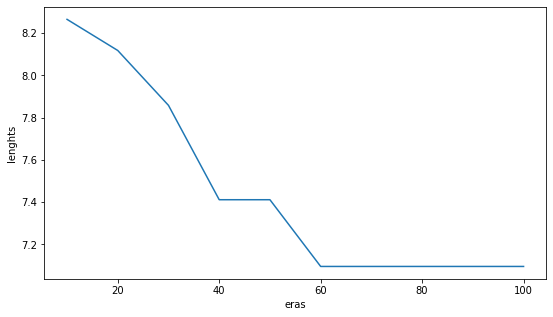

In [ ]:
# график сходимости
plt.figure(figsize=(9, 5))

plt.plot(eras, lenghts)

plt.xlabel('eras')
plt.ylabel('lenghts')
plt.show()

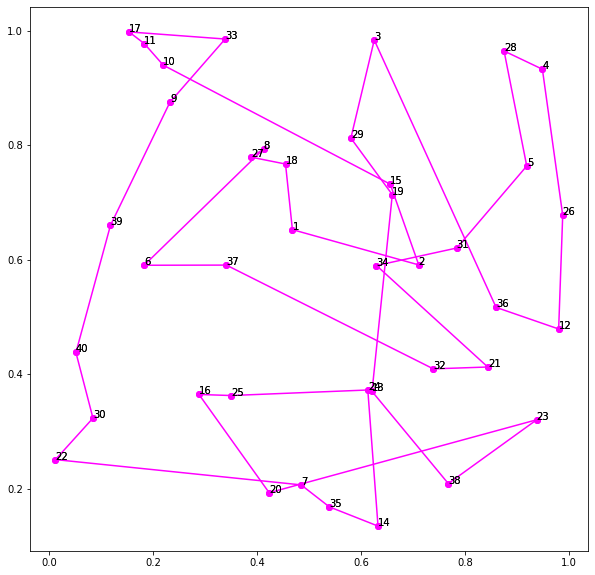

In [ ]:
# анимация пути
fig, ax = plt.subplots(figsize=(10, 10))

x_values, y_values = list(zip(*points_coordinate)) 


def animate(k):
    """Рисует оптимальный путь для каждого цикла жизни муравьев."""
    ax.clear()
    opt_path = paths[k] 
    for i, j in enumerate(opt_path[1:]):
        x = [x_values[opt_path[i] - 1], x_values[j - 1]]
        y = [y_values[opt_path[i] - 1], y_values[j - 1]]
        ax.plot(x, y, 'bo', c='magenta', linestyle='-')
        ax.annotate(str(opt_path[i]), xy=(x[0], y[0]))
        ax.annotate(str(j), xy=(x[1], y[1]))

    return ax


ani = FuncAnimation(fig, animate, frames=len(eras), interval=500, repeat=False)

In [ ]:
ani